In [1]:
import astropy
from scipy.optimize import minimize, curve_fit
from gaia_tools import query
import emcee
import corner
from scipy.interpolate import interp1d
from galpy.util import bovy_plot
from scipy.interpolate import CubicSpline
from galpy.util import bovy_coords, bovy_plot
import pandas

from misc import *
from misc import ncount
from random import randint

import warnings
warnings.simplefilter("ignore")

import matplotlib.colors as mcolors

%pylab inline

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Populating the interactive namespace from numpy and matplotlib


# Checks on Completeness

Throughout the paper, we make two large assumptions about completeness. The first is that the astrometric and photometric quality cuts on the data don't affect the results and can therefore be ignored. The second is that our sample is complete out to ~2 kpc over our entire apparent magnitude range. This notebook shows the analysis done to arrive at these conclusions. 

## Astrometric and Photometric Quality Cuts

Follows the analysis in **NumberCount.ipynb**

In [2]:
bprpMg_query='''SELECT -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag AS mg, bp_rp FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
AND parallax > 4'''

out= query.query(bprpMg_query,local=False)
query.cache.nickname(bprpMg_query,'cmd_query')

True

In [3]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
  
def findbin(mag,around):
    y,x= histogram(mag,bins=101)
    x= [(x[i]+x[i+1])/2. for i in range(101)]
    popt,pcov = curve_fit(gaus,x[argmax(y)-around[0]:argmax(y)+around[1]],y[argmax(y)-around[0]:argmax(y)+around[1]],p0=[350000.,x[argmax(y)],1.])

    xmodel= linspace(-3,15,10000)
    mean= popt[1]
    var= abs(popt[2])
    
    return [round(mean-2.*var,2),round(mean+2.*var,2)]

mg_cmd= out['mg']; bprp_cmd= out['bp_rp']
bprp_edges= arange(0.7,2.1+0.1,0.1)
Mg_edges= zeros((len(bprp_edges)-1,2))

for i in range(len(bprp_edges)-1):
    a= [5,7] if (i<13) else [17,17]
    if (i>16):
        a=[31,31]
    
    Mg_edges[i]= findbin(mg_cmd[(bprp_cmd>bprp_edges[i])*(bprp_cmd<bprp_edges[i+1])],around=a)

Query without the extra cuts:

In [4]:
queries= []
for i in range(len(Mg_edges)):
    queries.append("""SELECT cos(RADIANS(b))*(1/parallax)*cos(RADIANS(l)) AS x, 
cos(RADIANS(b))*(1/parallax)*sin(RADIANS(l)) AS y, 
(1/parallax)*sin(RADIANS(b)) AS z
FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag BETWEEN 7 AND 17
AND (1/parallax)*cos(RADIANS(b)) < 0.25 
AND parallax_over_error > 5
AND bp_rp BETWEEN {0:.2f} AND {1:.2f}
AND -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag BETWEEN {2:.1f} AND {3:.1f}"""\
          .format(bprp_edges[i],
                  bprp_edges[i+1],
                  Mg_edges[i,0],
                  Mg_edges[i,1]))

out= [None] * len(queries) # Output from the queries
bprp= [None] * len(queries) # X,Y,Z positions for the different colour bins

for i in range(len(queries)):
    out[i]= query.query(queries[i],local=False)
    bprp[i]= array([out[i]['x'],out[i]['y'],out[i]['z']])
for i,q in enumerate(queries):
    nick= 'ncount'+str(round(bprp_edges[i],1))
    query.cache.nickname(q,nick)

In [5]:
br_all= [None] * len(queries)

mag_data= [b.T for b in bprp]


binw_all= [0.025,0.025,0.025,0.025,0.025,0.025,0.02,0.02,0.02,0.015,0.015,
           0.015,0.01,0.01,0.01]
guess_all= [[0.8,0.03,0.1,0.1,0.5],[0.8,0.03,0.1,0.1,0.5],[0.8,0.03,0.2,0.1,0.5],
            [0.8,0.03,0.2,0.1,0.4],[0.8,0.03,0.2,0.15,0.4],[0.8,0.03,0.2,0.15,0.4],[0.7,0.03,0.2,0.15,0.4],
            [0.7,0.03,0.2,0.15,0.4],[0.6,0.03,0.2,0.15,0.4],[0.7,0.03,0.2,0.15,0.3],[0.7,0.03,0.2,0.25,0.4],
            [0.7,0.03,0.2,0.25,0.4],[0.7,0.03,0.2,0.25,0.4],[0.7,0.03,0.2,0.25,0.4],[0.8,0.03,0.1,0.1,0.4]]

for i in range(len(queries)):
    br_all[i]= ncount(mag_data[i],Mg_edges[i],bprp_edges[i],binw_all[i],guess_all[i],mcmc=True)

(20.339986909639304, 0.6615503684236326)


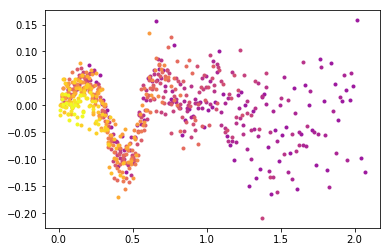

In [6]:
for b in br_all:
    b.plot_A()
    
print(bootstrap(array([b.z0_mcmc[0] for b in br_all])*1000,10000))

In [21]:
print(bootstrap(array([b.z0_mcmc[0] for b in br_all])*1000,10000))

(20.34389212666819, 0.6641793121549386)


Query with the extra cuts:

In [11]:
queries_q= []
for i in range(len(Mg_edges)):
    queries_q.append("""SELECT cos(RADIANS(b))*(1/parallax)*cos(RADIANS(l)) AS x, 
cos(RADIANS(b))*(1/parallax)*sin(RADIANS(l)) AS y, 
(1/parallax)*sin(RADIANS(b)) AS z
FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag BETWEEN 7 AND 17
AND (1/parallax)*cos(RADIANS(b)) < 0.25 
AND parallax_over_error > 5
AND bp_rp BETWEEN {0:.2f} AND {1:.2f}
AND -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag BETWEEN {2:.1f} AND {3:.1f}
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"""\
          .format(bprp_edges[i],
                  bprp_edges[i+1],
                  Mg_edges[i,0],
                  Mg_edges[i,1]))

out_q= [None] * len(queries_q) # Output from the queries
bprp_q= [None] * len(queries_q) # X,Y,Z positions for the different colour bins

for i in range(len(queries_q)):
    out_q[i]= query.query(queries_q[i],local=False)
    bprp_q[i]= array([out_q[i]['x'],out_q[i]['y'],out_q[i]['z']])
for i,q in enumerate(queries_q):
    nick_q= 'ncount_qual'+str(round(bprp_edges[i],1))
    query.cache.nickname(q,nick_q)    

In [12]:
br_all_q= [None] * len(queries_q)

mag_data_q= [b.T for b in bprp_q]

for i in range(len(queries_q)):
    br_all_q[i]= ncount(mag_data_q[i],Mg_edges[i],bprp_edges[i],binw_all[i],guess_all[i],mcmc=True)

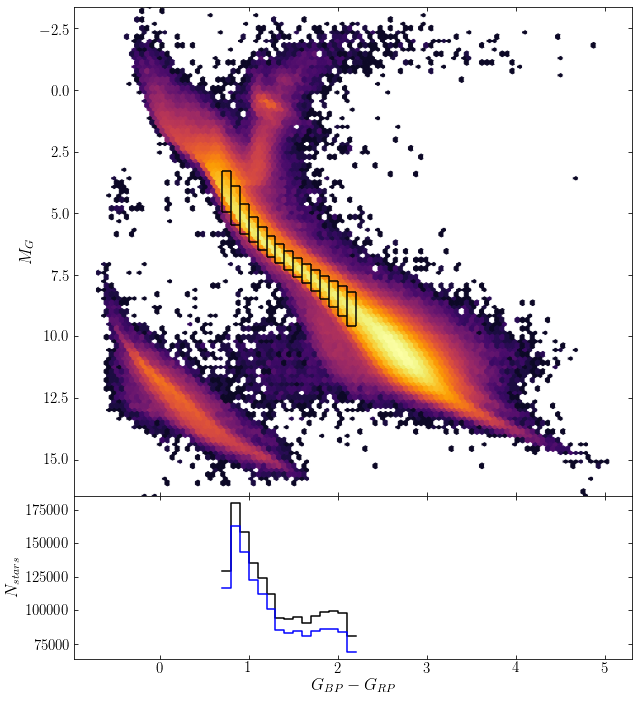

In [20]:
nstars_q= append(sum(br_all_q[0].N),[sum(b.N) for b in br_all_q])
nstars= append(sum(br_all[0].N),[sum(b.N) for b in br_all])

mgplot= zeros((len(bprp_edges)+1,2))
mgplot[1:-1]= Mg_edges; mgplot[0]=Mg_edges[0]; mgplot[-1]=Mg_edges[-1]

colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,12)

fig, (ax1,ax2)= subplots(2,sharex=True,gridspec_kw = {'height_ratios':[3, 1]})
fig.subplots_adjust(hspace=0)
ax1.hexbin(bprp_cmd,mg_cmd,bins='log',cmap=cmap,gridsize=100)
ax1.invert_yaxis()

for i in range(len(bprp_edges)):
    ax1.vlines(bprp_edges[i],mgplot[i][0],mgplot[i+1][1],color='k')
    if i<len(bprp_edges)-1:
        ax1.hlines(mgplot[i+1][0],bprp_edges[i],bprp_edges[i+1],color='k') 
        ax1.hlines(mgplot[i+1][1],bprp_edges[i],bprp_edges[i+1],color='k')
        
ax1.tick_params(axis='both')
ax1.set_ylabel(r'$M_G$')
ax2.set_xlabel(r'$G_{BP}-G_{RP}$')
ax2.tick_params(axis='both')
ax2.set_ylabel(r'$N_{stars}$')

ax2.step(bprp_edges,nstars,'k')
ax2.step(bprp_edges,nstars_q,'b')

## Test Distances to which 1/parallax is accurate

In [22]:
q= '''SELECT parallax_error,parallax_over_error FROM gaiadr2.gaia_source
WHERE (1/parallax)*cos(RADIANS(b)) < 0.25
AND parallax>0
AND phot_g_mean_mag BETWEEN 16.5 AND 17 '''

In [24]:
out= query.query(q,local=False)
query.cache.nickname(q,'mag_check')

Query finished.


True

In [11]:
pe= out['parallax_error']

In [13]:
dist= 1/(median(pe)*5)
print(median(pe))
print('''The furthest distance to which we can trust parallax as a measure of
distance is: ''',dist, 'kpc') 
print('Accounting for radius of the cylinder',sqrt(dist**2-0.25**2),'kpc')

0.09531313867704089
The furthest distance to which we can trust parallax as a measure of distance is:  2.098346594981833 kpc
Accounting for radius of the cylinder 2.083400689419069 kpc
